In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
from typing import List, Tuple
import datetime

In [3]:
DATA_CSV = Path("../data/csv/")

In [4]:
protons_df = [pd.read_csv(path) for path in glob.glob("../data/csv/protons_2024*.csv")][0]
protons_df['time'] = pd.to_datetime(protons_df['time'])
electrons_df = [pd.read_csv(path) for path in glob.glob("../data/csv/electrons_2024*.csv")][0]
electrons_df['time'] = pd.to_datetime(electrons_df['time'])

In [5]:
protons_df

,time,bin,value
0,2023-09-01 00:00:56,1,6
1,2023-09-01 00:00:56,2,222
2,2023-09-01 00:00:56,3,27
3,2023-09-01 00:00:56,4,21
4,2023-09-01 00:00:56,5,18
...,...,...,...
3209548,2024-05-07 15:36:46,4,25
3209549,2024-05-07 15:36:46,5,19
3209550,2024-05-07 15:36:46,6,29
3209551,2024-05-07 15:36:46,7,25


In [6]:
electrons_df

,time,bin,value
0,2023-09-01 00:00:56,1,5
1,2023-09-01 00:00:56,2,16
2,2023-09-01 00:00:56,3,28
3,2023-09-01 00:00:56,4,11
4,2023-09-01 00:00:56,5,18
...,...,...,...
3209548,2024-05-07 15:36:46,4,10
3209549,2024-05-07 15:36:46,5,11
3209550,2024-05-07 15:36:46,6,23
3209551,2024-05-07 15:36:46,7,101


In [8]:
def scatter_bins(
        counts_df: pd.DataFrame,
        bins: List[int] | int,
        interval: Tuple[datetime.datetime, datetime.datetime] = None,
        noise_overlay: pd.DataFrame = None
    ) -> None:
    
    if isinstance(bins, int):
        bins = [bins]
    
    if not interval is None:
        start, end = interval
        counts_df = counts_df[(counts_df['time'] >= start) & (counts_df['time'] <= end)]
        plt.xlim(start, end)


    if not interval is None and not noise_overlay is None:
        start, end = interval
        noise_overlay = noise_overlay[(noise_overlay['time'] >= start) & (noise_overlay['time'] <= end)]


    plt.xlabel("Measurement date")
    plt.ylabel("Counts")
    plt.xticks(rotation=70)

    df = counts_df.resample("15min", on='time').mean()
    df = df.reset_index()

    if not noise_overlay is None:
        noise_overlay = noise_overlay.resample("15min", on='time').mean()
        noise_overlay = noise_overlay.reset_index()
        plt.scatter(x=noise_overlay["time"], y=noise_overlay["noise"])

    for bin in bins:
        df = counts_df[counts_df["bin"]==bin]
        plt.scatter(x=df["time"], y=df["value"])
        
    plt.show()

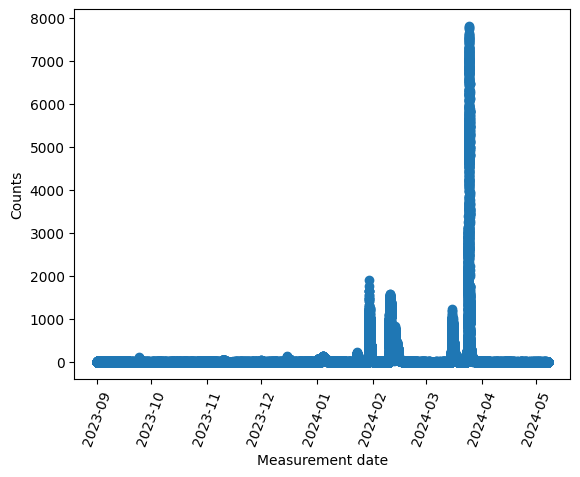

In [9]:
interval = None #datetime.datetime(2024, 3, 23), datetime.datetime(2024, 3, 27)
scatter_bins(protons_df, 1, interval)

## Simple Approach
Take a rolling window approach to compute noise for a small window.

In [10]:
def plot_rolling_window_noise(counts_df: pd.DataFrame, bin: int, window_size: int, interval: Tuple[datetime.datetime, datetime.datetime] = None) -> None:
    df = counts_df[counts_df["bin"]==bin]
    rolling_mean = df["value"].rolling(window=window_size, center=True).mean()
    rolling_std = df["value"].rolling(window=window_size, center=True).std()
    noise_df = pd.DataFrame({
        "time": df["time"],
        "noise": rolling_mean
    })

    scatter_bins(df, bins=bin, noise_overlay=noise_df, interval=interval)

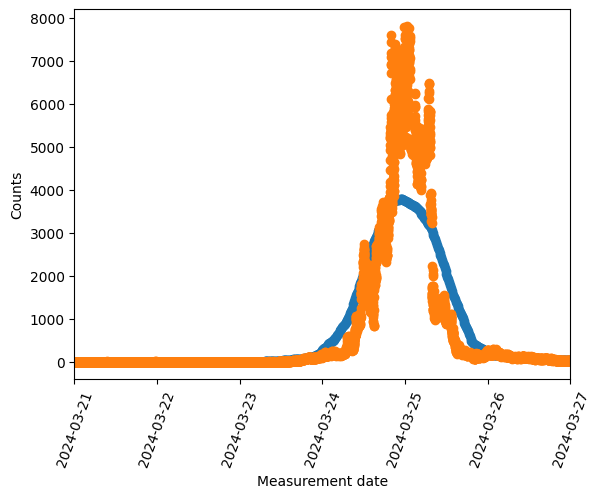

In [11]:
interval = datetime.datetime(2024, 3, 21), datetime.datetime(2024, 3, 27)
window_size =  24 * 60 # One day long rolling window

plot_rolling_window_noise(protons_df, 1, window_size, interval)

## Main idea of the noise discriminant
Having computed the rolling mean and rolling std of a sliding window of data we can say with confidence that the noise levels we're searching for will be stable for a long period of time (this being a day or two). We can compare the parameters of rolling distributions with a z-score to determine whether a given interval is made up of noise or a possible event.

In [12]:
full_interval = datetime.datetime(2024, 2, 15), datetime.datetime(2024, 4, 15)

In [26]:
def intervals_from_mask(mask: np.array) -> List[Tuple[datetime.datetime, datetime.datetime]]:
    # Find the change points in the mask
    changes = np.diff(mask.astype(int))

    # Start of intervals where mask is True (change from 0 to 1)
    starts = np.where(changes == 1)[0] + 1

    # End of intervals where mask is True (change from 1 to 0)
    ends = np.where(changes == -1)[0] + 1

    # Handle edge cases where the mask starts or ends with True
    if mask[0]:
        starts = np.insert(starts, 0, 0)
    if mask[-1]:
        ends = np.append(ends, len(mask))

    intervals = list(zip(starts, ends))
    return intervals

def noise_mask(df: pd.DataFrame, rolling_window: int, offsets: List[int], full_interval: Tuple[datetime.datetime, datetime.datetime] = None) -> np.array:
    """Returns only the noise from the full search interval"""
    if not full_interval is None:
        start, end = full_interval
        df = df[(df['time'] >= start) & (df['time'] <= end)]

    rolling_mean = np.array(df["value"].rolling(window=rolling_window, center=True).mean())
    rolling_std = np.array(df["value"].rolling(window=rolling_window, center=True).std())

    mask = np.ones(len(df), dtype=bool) # Accepts all
    for offset in offsets:
        z_scores_forward = np.zeros(len(rolling_mean))
        z_scores_backward = np.zeros(len(rolling_mean))
        for i in range(offset, len(df) - offset):
            z_scores_forward[i] = (rolling_mean[i] - rolling_mean[i + offset]) / rolling_std[i + offset]
            z_scores_backward[i] = (rolling_mean[i] - rolling_mean[i - offset]) / rolling_std[i - offset]
        noise_mask = (np.abs(z_scores_forward) < 3) & (np.abs(z_scores_backward) < 3)
        mask = mask & noise_mask
    
    
    return mask

/tmp/ipykernel_123942/2089904848.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noise["noise"] = noise["value"] + 1000.0


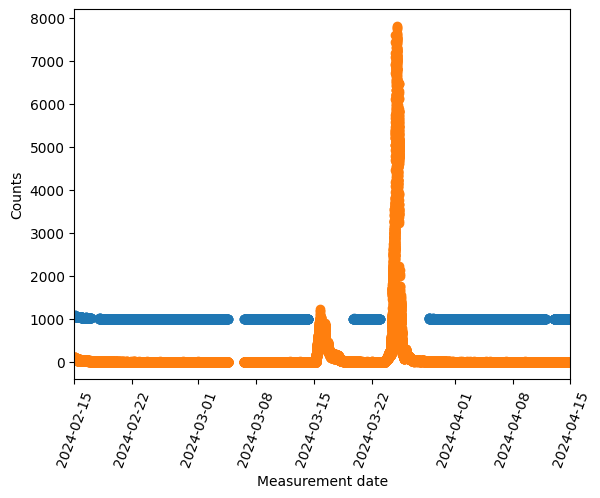

In [29]:
df = protons_df[protons_df["bin"] == 1]
df = df[(df['time'] >= full_interval[0]) & (df['time'] <= full_interval[1])]

offsets =  [2 * 24 * 60]
mask = noise_mask(df, rolling_window=2 * 24 * 60, offsets=offsets, full_interval=full_interval)
noise = df[mask]
noise["noise"] = noise["value"] + 1000.0

scatter_bins(df, bins=1, interval=full_interval, noise_overlay=noise)

In [15]:
def plot_only_noise(df: pd.DataFrame, bin: int, interval: Tuple[datetime.datetime, datetime.datetime] = None) -> None:
    df = df[df["bin"]==bin]
    
    
    if not interval is None:
        start, end = interval
        df = df[(df['time'] >= start) & (df['time'] <= end)]
        plt.xlim(start, end)

    plt.xlabel("Measurement date")
    plt.ylabel("Counts")
    plt.xticks(rotation=70)

    offsets =  [2 * 24 * 60]
    mask = noise_mask(df, rolling_window=2 * 24 * 60, offsets=offsets, full_interval=interval)
    df = mask

    noise_intervals = intervals_from_mask(mask)

    time = np.array(df["time"])

    df = df.resample("15min", on='time').mean()
    df = df.reset_index()
    plt.scatter(x=df["time"], y=df["value"])
    
    # Mark the intervals on the plot using shaded regions

    plt.show()

KeyError: 0

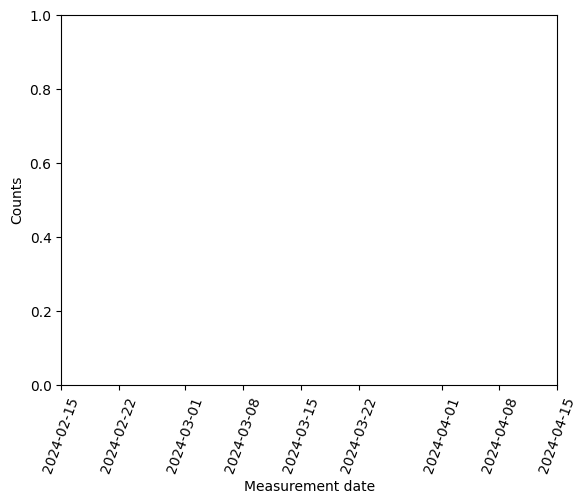

In [252]:
plot_only_noise(protons_df, 1, full_interval)